## Naudojamų kodo bibliotekų įkėlimas

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random

## Naudojamo įrenginio nustatymas (GPU ir TPU)
Galima pasirinkti, kurį įrenginį norime naudoti. Abu variantai veikia su **Google Colab** sistema, taip pat ir lokaliai.

### Kodas tikrinantis pasiekiamus GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU is available: {gpus[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU is available.")

GPU is available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Kodas tikrinantis pasiekiamus TPU

In [ ]:
'''
try:
    # Automatiškai nustatatomas TPU ir jis inicijuojamas
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("Running on TPU:", resolver.master())
    print("All devices:", tf.config.list_logical_devices('TPU'))
except Exception as e:
    print("Failed to connect to TPU:", e)
    strategy = tf.distribute.get_strategy()
'''

'\ntry:\n    # Automatically detect the TPU and initialize it\n    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()\n    tf.config.experimental_connect_to_cluster(resolver)\n    tf.tpu.experimental.initialize_tpu_system(resolver)\n    strategy = tf.distribute.TPUStrategy(resolver)\n    print("Running on TPU:", resolver.master())\n    print("All devices:", tf.config.list_logical_devices(\'TPU\'))\nexcept Exception as e:\n    print("Failed to connect to TPU:", e)\n    strategy = tf.distribute.get_strategy()\n'

## Duomenų rinkinio Fashion MNIST užkrovimas naudojant TensorFlow ir Keras
Fashion MNIST duomenų rinkinys yra 28x28 paveikslėlių rinkinys, kuris sudarytas iš 60,000 mokymo pavyzdžių ir 10,000 testavimo pavyzdžių.

### Klasifikavimo klasės

Kiekvienam mokymo ir testavimo pavyzdžiui priskiriama viena iš šių klasių:

* **0** marškinėliai/palaidinė
* **1** Kelnės
* **2** Megztinis
* **3** Suknelė
* **4** Paltas
* **5** Sandalas
* **6** Marškiniai
* **7** Sportbatis
* **8** Krepšys
* **9** Batas iki kulkšnies

In [3]:
# Fashion MNIST duomenų rinkinio užkrovimas
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Sujungiami mokymo ir testavimo duomenų rinkiniai
combined_images = np.concatenate((train_images, test_images))
combined_labels = np.concatenate((train_labels, test_labels))

# Nustatomas klasių numeravimas nuo 0 iki 9
combined_labels = to_categorical(combined_labels, num_classes=10)

# Normalizuojami paveikslėliai, kad jie turėtų reikšmes tarp 0 ir 1
combined_images = combined_images.astype('float32') / 255

# Išskaidomas sujungtas duomenų rinkinys į naujus mokymo, validavimo ir testavimo rinkinius
train_images, temp_images, train_labels, temp_labels = train_test_split(
    combined_images, combined_labels, test_size=0.2, random_state=42)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42)

# Mokymo, validavimo ir testavimo rinkinių paveikslėlių formos ir dydžiai
print("Training set images shape:", train_images.shape)
print("Validation set images shape:", val_images.shape)
print("Test set images shape:", test_images.shape)
print("Training set labels shape:", train_labels.shape)
print("Validation set labels shape:", val_labels.shape)
print("Test set labels shape:", test_labels.shape)

4422102/4422102 [==============================] - 0s 0us/step
Training set images shape: (56000, 28, 28)
Validation set images shape: (7000, 28, 28)
Test set images shape: (7000, 28, 28)
Training set labels shape: (56000, 10)
Validation set labels shape: (7000, 10)
Test set labels shape: (7000, 10)


### Duomenų rinkinių paruošimas modelio apmokymui
Pirmiausia yra nustatoma taisyklinga duomenų rinkinio (batch) forma, tada yra išmaišomi duomenys ir iš anksto užkraunami greitiasniam mokymui.

In [4]:
batch_size = 32

# Pakeičiame paveikslėlių formą į (32, 28, 28, 1). 32 - batch dydis, 28x28 - paveikslėlio dydis, 1 - spalvų kanalų skaičius
train_images = train_images.reshape((-1, 28, 28, 1))
val_images = val_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(train_labels.size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Datasets created successfully.\n")
for images, labels in train_dataset.take(1):
  print(f'Train batch images shape: {images.shape}')
  print(f'Train batch labels shape: {labels.shape}')

for images, labels in val_dataset.take(1):
  print(f'Validation batch images shape: {images.shape}')
  print(f'Validation batch labels shape: {labels.shape}')

for images, labels in test_dataset.take(1):
  print(f'Test batch images shape: {images.shape}')
  print(f'Test batch labels shape: {labels.shape}')

Datasets created successfully.

Train batch images shape: (32, 28, 28, 1)
Train batch labels shape: (32, 10)
Validation batch images shape: (32, 28, 28, 1)
Validation batch labels shape: (32, 10)
Test batch images shape: (32, 28, 28, 1)
Test batch labels shape: (32, 10)


## Konvoliucinio neuroninio tinklo modelis sukūrimas ir apmokymas

### Modelio sukūrimas
Kadangi tyrimui atlikti reikia išbandyti daug modelio variantų ir naudojamų optimizavimo su nuostolių funkcijų, tam buvo paruošta funkcija, kuri pagal paduodamus parametrus parenka atitinkamą modelį.

In [3]:
def create_model(architecture_type, optimizer='adam', learning_rate=0.001):
  # Ši eilutė leidžia naudoti TPU (šiuo atveju neveikia, nes naudojamas GPU)
  # with strategy.scope():
  model = Sequential()
  if architecture_type == 'basic':
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

  elif architecture_type == 'intermediate':
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
  elif architecture_type == 'advanced':
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

  if optimizer == 'adam':
    opt = Adam(learning_rate=learning_rate)
  elif optimizer == 'sgd':
    opt = SGD(learning_rate=learning_rate)
  elif optimizer == 'rmsprop':
    opt = RMSprop(learning_rate=learning_rate)

  model.compile(
    optimizer=opt,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy'],
  )

  model.summary()
  return model


### Ankstyvo sustabdymo ir mokymo žingsnio dydžio mažinimo panaudojimas

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=1e-8)

### Modelio apmokymas su visais skirtingais variantais (*basic, intermediate ir advanced*) ir pradiniais mokymo žingsniais (*nuo 10e-6 iki 10e-2*)

Training basic model:
Epoch 1/100
1750/1750 [==============================] - 23s 6ms/step - loss: 2.2886 - accuracy: 0.1019 - val_loss: 2.2718 - val_accuracy: 0.1313 - lr: 1.0000e-06
Epoch 2/100
1750/1750 [==============================] - 7s 4ms/step - loss: 2.2540 - accuracy: 0.1834 - val_loss: 2.2343 - val_accuracy: 0.2787 - lr: 1.0000e-06
Epoch 3/100
1750/1750 [==============================] - 8s 5ms/step - loss: 2.2091 - accuracy: 0.3242 - val_loss: 2.1811 - val_accuracy: 0.3574 - lr: 1.0000e-06
Epoch 4/100
1750/1750 [==============================] - 8s 4ms/step - loss: 2.1471 - accuracy: 0.3785 - val_loss: 2.1099 - val_accuracy: 0.4051 - lr: 1.0000e-06
Epoch 5/100
1750/1750 [==============================] - 8s 5ms/step - loss: 2.0662 - accuracy: 0.4187 - val_loss: 2.0178 - val_accuracy: 0.4313 - lr: 1.0000e-06
Epoch 6/100
1750/1750 [==============================] - 8s 5ms/step - loss: 1.9642 - accuracy: 0.4504 - val_loss: 1.9076 - val_accuracy: 0.4639 - lr: 1.0000e-06
Epoch

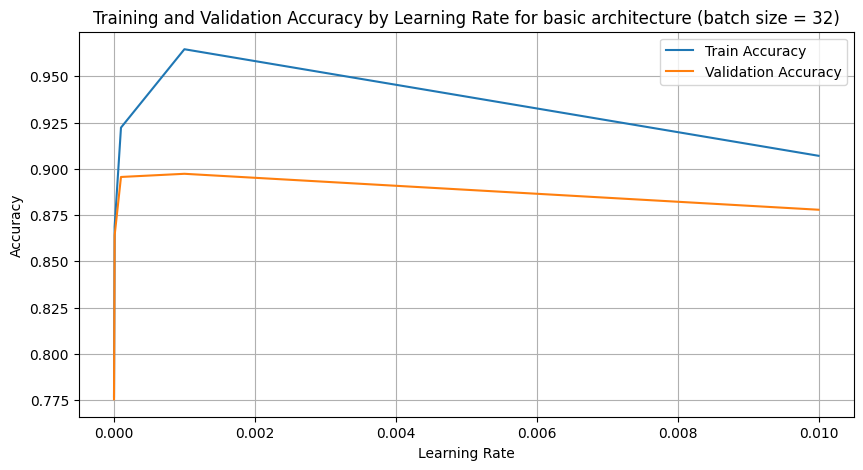

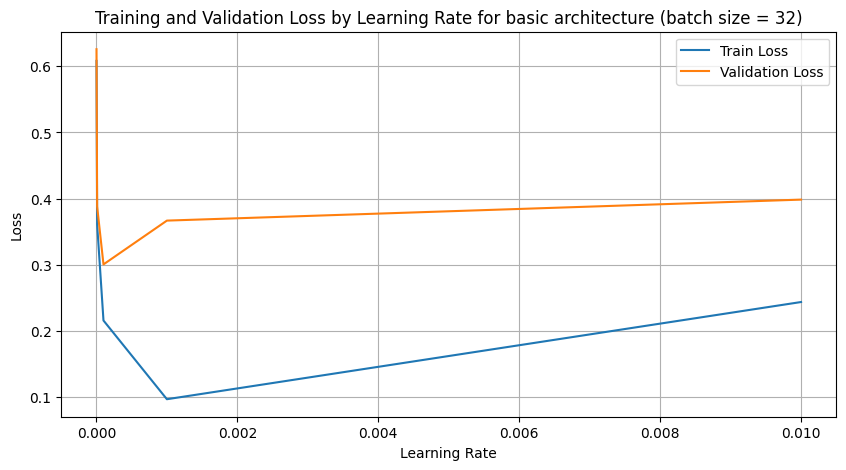

Training intermediate model:
Epoch 1/100
1750/1750 [==============================] - 12s 6ms/step - loss: 2.2915 - accuracy: 0.1234 - val_loss: 2.2753 - val_accuracy: 0.1466 - lr: 1.0000e-06
Epoch 2/100
1750/1750 [==============================] - 8s 5ms/step - loss: 2.2505 - accuracy: 0.1831 - val_loss: 2.2267 - val_accuracy: 0.3193 - lr: 1.0000e-06
Epoch 3/100
1750/1750 [==============================] - 9s 5ms/step - loss: 2.1866 - accuracy: 0.2560 - val_loss: 2.1498 - val_accuracy: 0.4687 - lr: 1.0000e-06
Epoch 4/100
1750/1750 [==============================] - 9s 5ms/step - loss: 2.0937 - accuracy: 0.3142 - val_loss: 2.0421 - val_accuracy: 0.5014 - lr: 1.0000e-06
Epoch 5/100
1750/1750 [==============================] - 8s 5ms/step - loss: 1.9792 - accuracy: 0.3494 - val_loss: 1.9098 - val_accuracy: 0.5206 - lr: 1.0000e-06
Epoch 6/100
1750/1750 [==============================] - 10s 6ms/step - loss: 1.8550 - accuracy: 0.3810 - val_loss: 1.7698 - val_accuracy: 0.5114 - lr: 1.0000e-

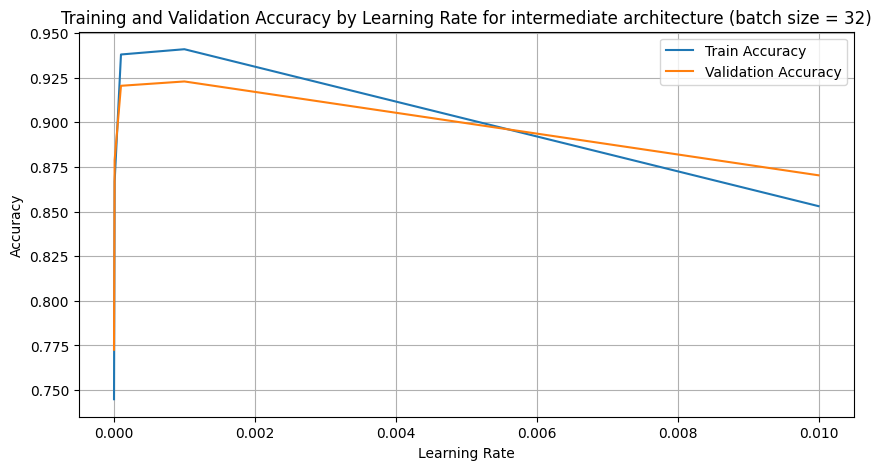

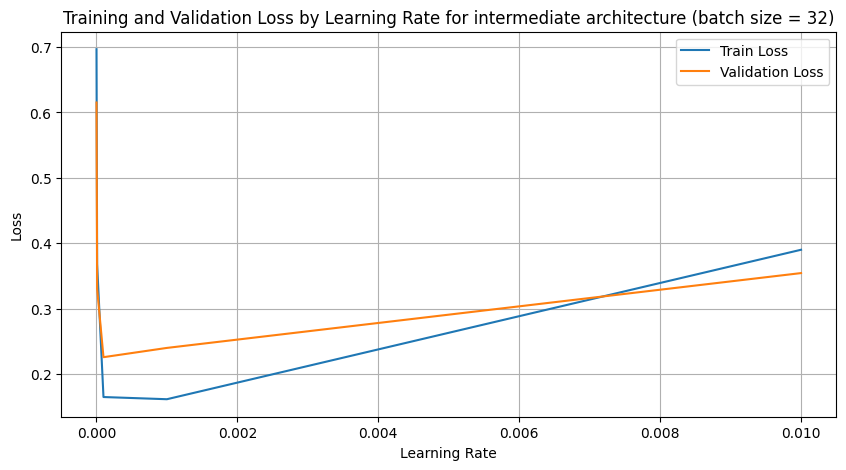

Training advanced model:
Epoch 1/100
1750/1750 [==============================] - 14s 6ms/step - loss: 2.3011 - accuracy: 0.1156 - val_loss: 2.2950 - val_accuracy: 0.1947 - lr: 1.0000e-06
Epoch 2/100
1750/1750 [==============================] - 11s 6ms/step - loss: 2.2909 - accuracy: 0.1462 - val_loss: 2.2815 - val_accuracy: 0.3384 - lr: 1.0000e-06
Epoch 3/100
1750/1750 [==============================] - 11s 6ms/step - loss: 2.2765 - accuracy: 0.1711 - val_loss: 2.2607 - val_accuracy: 0.4206 - lr: 1.0000e-06
Epoch 4/100
1750/1750 [==============================] - 11s 6ms/step - loss: 2.2537 - accuracy: 0.1966 - val_loss: 2.2242 - val_accuracy: 0.4387 - lr: 1.0000e-06
Epoch 5/100
1750/1750 [==============================] - 11s 6ms/step - loss: 2.2162 - accuracy: 0.2261 - val_loss: 2.1625 - val_accuracy: 0.4559 - lr: 1.0000e-06
Epoch 6/100
1750/1750 [==============================] - 11s 6ms/step - loss: 2.1566 - accuracy: 0.2574 - val_loss: 2.0670 - val_accuracy: 0.4741 - lr: 1.0000e-

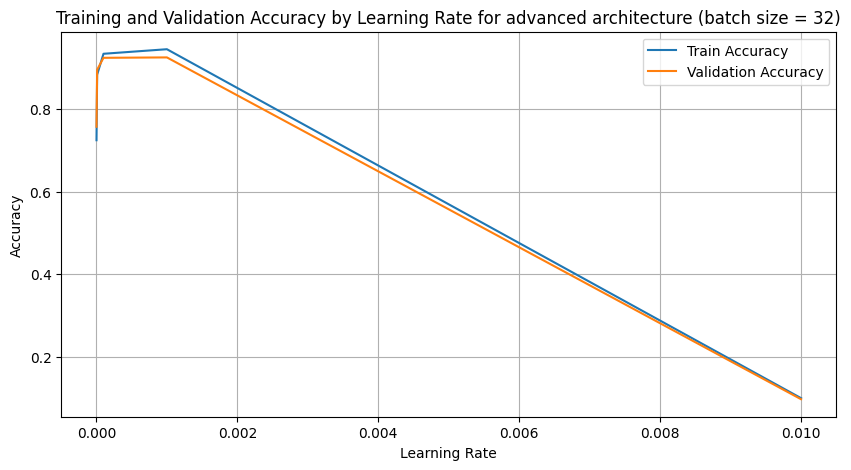

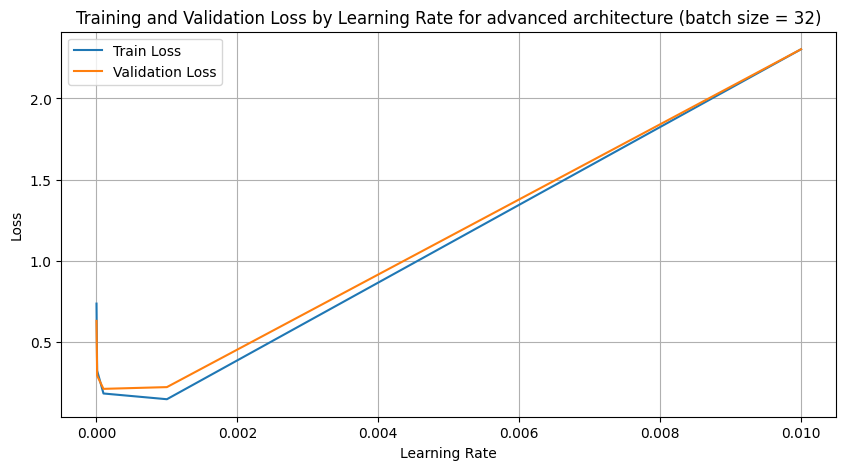

In [ ]:
results = {}
learning_rates = np.logspace(-6, -2, num=5)

for architecture in ['basic', 'intermediate', 'advanced']:
  print(f"Training {architecture} model:")
  results[architecture] = {}

  for lr in learning_rates:
    # Modelio sukūrimas
    model = create_model(architecture, learning_rate=lr)

    # Modelio apmokymas
    history = model.fit(
      train_dataset,
      epochs=100,
      validation_data=val_dataset,
      callbacks=[early_stopping, reduce_lr],
    )

    # Gaunamos paskutinės epochos metrikos
    last_train_accuracy = history.history['accuracy'][-1]
    last_val_accuracy = history.history['val_accuracy'][-1]
    last_train_loss = history.history['loss'][-1]
    last_val_loss = history.history['val_loss'][-1]

    results[architecture][lr] = {
      'last_train_accuracy': last_train_accuracy,
      'last_val_accuracy': last_val_accuracy,
      'last_train_loss': last_train_loss,
      'last_val_loss': last_val_loss
    }

## Logaritminių skalių pateikimas kiekvienam modeliui

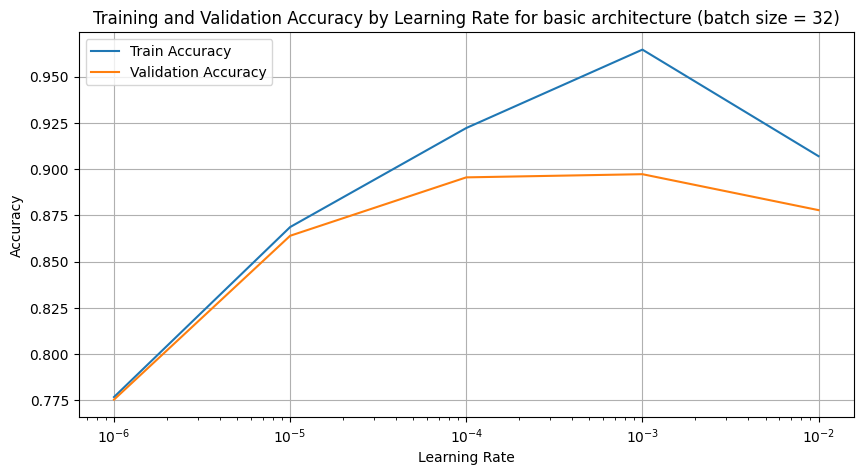

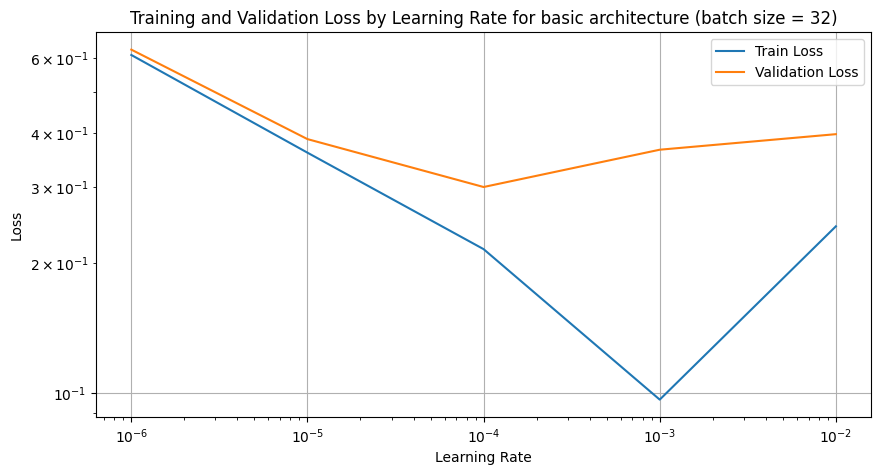

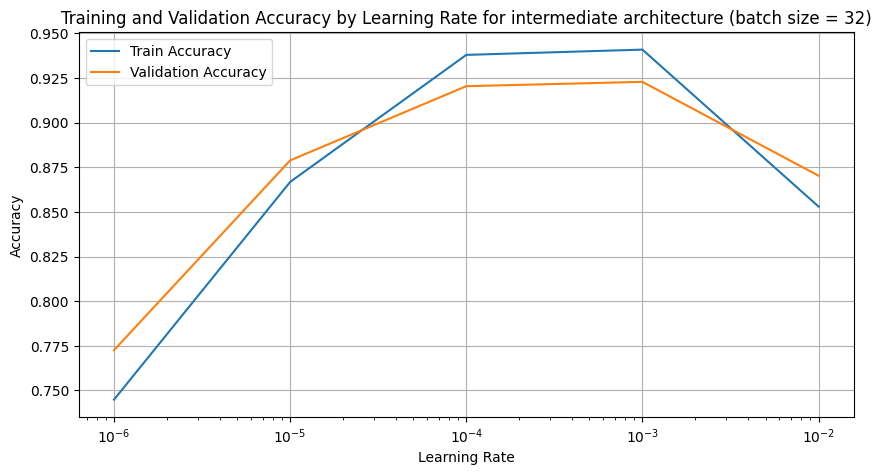

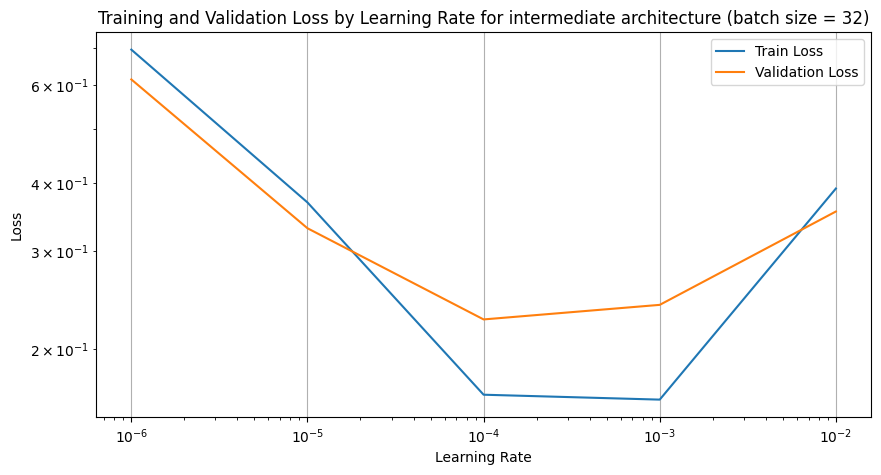

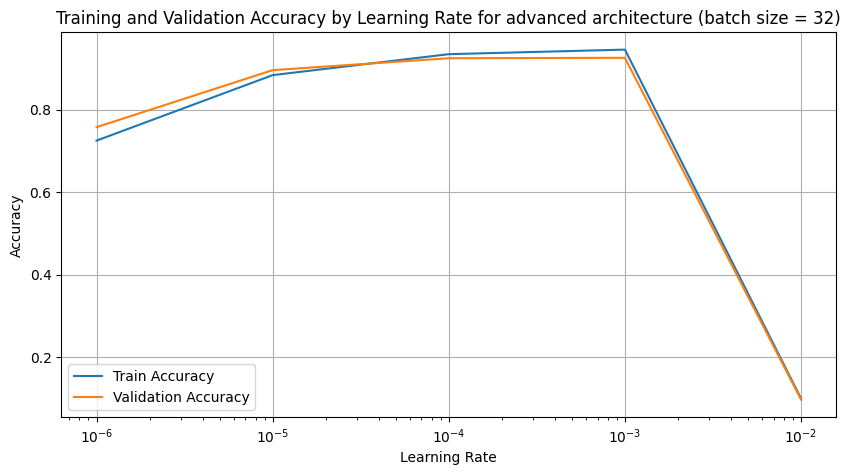

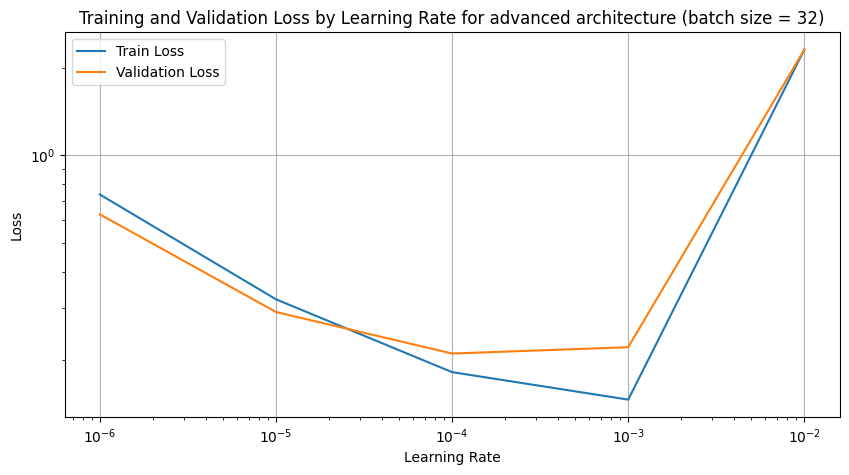

In [ ]:
for architecture in ['basic', 'intermediate', 'advanced']:
  lrs = list(results[architecture].keys())
  train_accuracies = [results[architecture][lr]['last_train_accuracy'] for lr in lrs]
  val_accuracies = [results[architecture][lr]['last_val_accuracy'] for lr in lrs]
  train_losses = [results[architecture][lr]['last_train_loss'] for lr in lrs]
  val_losses = [results[architecture][lr]['last_val_loss'] for lr in lrs]

  # Nustatomas grafikai su nuostolių ir tikslumo metrikomis
  plt.figure(figsize=(10, 5))
  plt.plot(lrs, train_accuracies, label='Train Accuracy')
  plt.plot(lrs, val_accuracies, label='Validation Accuracy')
  plt.title(f'Training and Validation Accuracy by Learning Rate for {architecture} architecture (batch size = {batch_size})')
  plt.xlabel('Learning Rate')
  plt.ylabel('Accuracy')
  plt.xscale('log')
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(lrs, train_losses, label='Train Loss')
  plt.plot(lrs, val_losses, label='Validation Loss')
  plt.title(f'Training and Validation Loss by Learning Rate for {architecture} architecture (batch size = {batch_size})')
  plt.xlabel('Learning Rate')
  plt.ylabel('Loss')
  plt.xscale('log')
  plt.yscale('log')
  plt.legend()
  plt.grid(True)
  plt.show()

## Modelių mokynimas su skirtingomis optimizavimo funkcijomis
Pagal prieš tai apmokintų modelių metrikas yra paimtas geriausias modelio variantas su atitinkamu pradinių mokymo žingsnio dydžiu.

**Geriausias rastas variantas:** `advanced` modelis su `10e-4` pradiniu mokymo žingsniu.

In [ ]:
new_results = {}

for optimizer in ['adam', 'sgd', 'rmsprop']:
  new_results[optimizer] = {}
  print(f"Training model with {optimizer} optimization function:")
  # Modelio sukūrimas
  model = create_model(architecture_type='advanced', optimizer=optimizer, learning_rate=0.0001)

  # Modelio apmokymas
  history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
  )

  # Gaunamos paskutinės epochos metrikos
  last_train_accuracy = history.history['accuracy'][-1]
  last_val_accuracy = history.history['val_accuracy'][-1]
  last_train_loss = history.history['loss'][-1]
  last_val_loss = history.history['val_loss'][-1]

  new_results[optimizer] = {
    'last_train_accuracy': last_train_accuracy,
    'last_val_accuracy': last_val_accuracy,
    'last_train_loss': last_train_loss,
    'last_val_loss': last_val_loss
  }

  # Išsaugojamas modelis
  model_filename = f"model_{optimizer}.h5"
  model.save(model_filename)
  print(f"Model saved as {model_filename}")

Training model with adam optimization function:
Epoch 1/100
1750/1750 [==============================] - 53s 28ms/step - loss: 1.0299 - accuracy: 0.6207 - val_loss: 0.6007 - val_accuracy: 0.7670 - lr: 1.0000e-04
Epoch 2/100
1750/1750 [==============================] - 40s 23ms/step - loss: 0.6629 - accuracy: 0.7487 - val_loss: 0.5197 - val_accuracy: 0.8039 - lr: 1.0000e-04
Epoch 3/100
1750/1750 [==============================] - 25s 14ms/step - loss: 0.5742 - accuracy: 0.7849 - val_loss: 0.4587 - val_accuracy: 0.8309 - lr: 1.0000e-04
Epoch 4/100
1750/1750 [==============================] - 24s 14ms/step - loss: 0.5155 - accuracy: 0.8097 - val_loss: 0.4231 - val_accuracy: 0.8404 - lr: 1.0000e-04
Epoch 5/100
1750/1750 [==============================] - 26s 15ms/step - loss: 0.4693 - accuracy: 0.8281 - val_loss: 0.3877 - val_accuracy: 0.8560 - lr: 1.0000e-04
Epoch 6/100
1750/1750 [==============================] - 26s 15ms/step - loss: 0.4299 - accuracy: 0.8435 - val_loss: 0.3587 - val_ac

## Naujų logaritminių skalių pateikimas kiekvienam modeliui

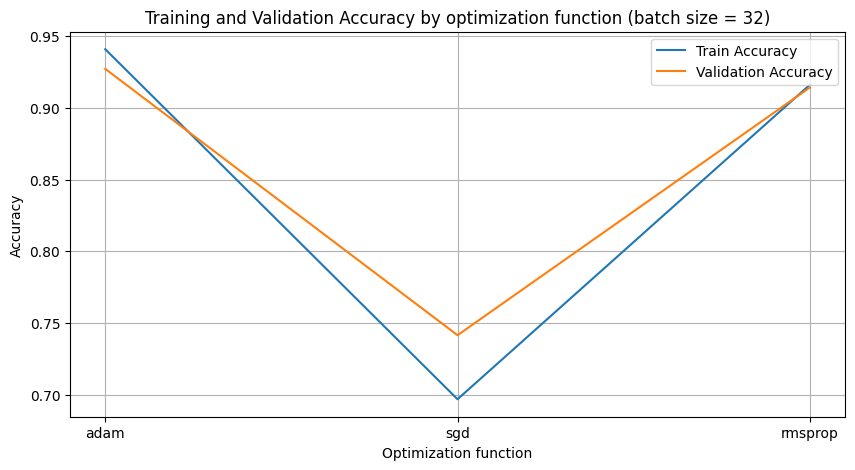

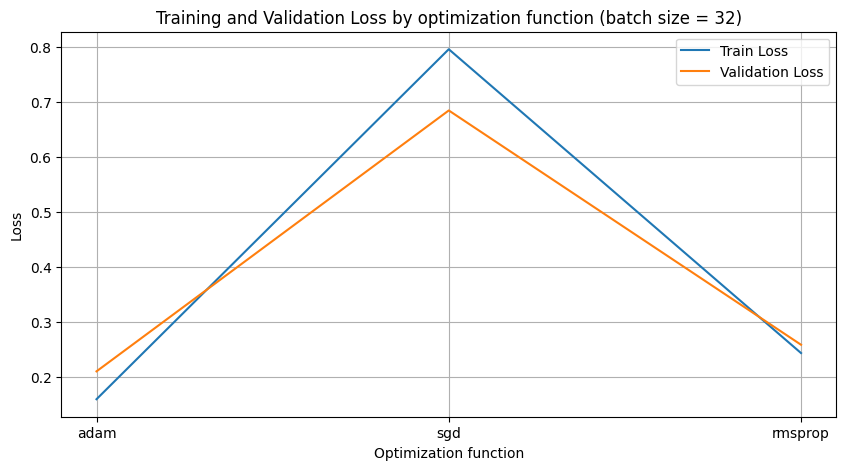

In [ ]:
optimizers = list(new_results.keys())
train_accuracies = [new_results[optimizer]['last_train_accuracy'] for optimizer in optimizers]
val_accuracies = [new_results[optimizer]['last_val_accuracy'] for optimizer in optimizers]
train_losses = [new_results[optimizer]['last_train_loss'] for optimizer in optimizers]
val_losses = [new_results[optimizer]['last_val_loss'] for optimizer in optimizers]

# Nustatomas grafikai su nuostolių ir tikslumo metrikomis
plt.figure(figsize=(10, 5))
plt.plot(optimizers, train_accuracies, label='Train Accuracy')
plt.plot(optimizers, val_accuracies, label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy by optimization function (batch size = {batch_size})')
plt.xlabel('Optimization function')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(optimizers, train_losses, label='Train Loss')
plt.plot(optimizers, val_losses, label='Validation Loss')
plt.title(f'Training and Validation Loss by optimization function (batch size = {batch_size})')
plt.xlabel('Optimization function')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Testavimo duomenų klasifikavimo duomenys

### Modelio įkėlimas

In [6]:
test_model = load_model("model_adam.h5")

### Klasifikavimo tikslumo ir mažiausios paklaidos paskaičiavimas su klasifikavimo matrica

219/219 [==============================] - 4s 16ms/step - loss: 0.1811 - accuracy: 0.9317

Test Loss: 0.18114188313484192
Test Accuracy: 0.9317142963409424

1/1 [==============================] - 0s 169ms/step


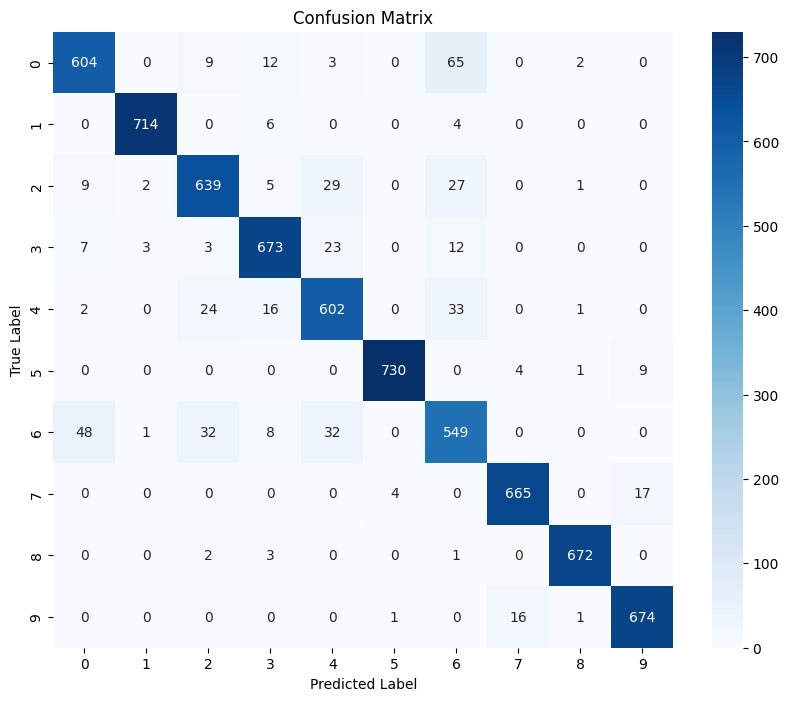

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       695
           1       0.99      0.99      0.99       724
           2       0.90      0.90      0.90       712
           3       0.93      0.93      0.93       721
           4       0.87      0.89      0.88       678
           5       0.99      0.98      0.99       744
           6       0.79      0.82      0.81       670
           7       0.97      0.97      0.97       686
           8       0.99      0.99      0.99       678
           9       0.96      0.97      0.97       692

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000



In [7]:
# Modelio testavimas
test_loss, test_accuracy = test_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}\n")

# Gaunamos modelio prognozės ir tikri duomenys iš testavimo rinkinio
y_pred = []
y_true = []

for images, labels in test_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    predictions = test_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Sukuriama ir atvaizduojama klasifikavimo matrica
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))

In [8]:
# Gaunami atsitiktiniai testavimo rinkinio paveikslėliai ir jų tikrosios klasės
sample_size = 30
test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.extend(images.numpy())
    test_labels.extend(np.argmax(labels.numpy(), axis=1))

# Pasirenkami atsitiktiniai paveikslėliai iš testavimo rinkinio
random_indices = random.sample(range(len(test_images)), sample_size)
sample_images = np.array([test_images[i] for i in random_indices])
sample_true_labels = np.array([test_labels[i] for i in random_indices])

# Gaunamos modelio prognozės
sample_predictions = test_model.predict(sample_images)
sample_predicted_labels = np.argmax(sample_predictions, axis=1)

print("Sample Predictions (Predicted vs True):")
for i in range(sample_size):
    print(f"Predicted: {sample_predicted_labels[i]}, True: {sample_true_labels[i]}")

1/1 [==============================] - 0s 34ms/step
Sample Predictions (Predicted vs True):
Predicted: 0, True: 6
Predicted: 0, True: 0
Predicted: 4, True: 4
Predicted: 5, True: 5
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 9, True: 9
Predicted: 2, True: 2
Predicted: 0, True: 0
Predicted: 8, True: 8
Predicted: 7, True: 7
Predicted: 3, True: 3
Predicted: 1, True: 1
Predicted: 8, True: 8
Predicted: 9, True: 9
Predicted: 3, True: 3
Predicted: 8, True: 8
Predicted: 5, True: 5
Predicted: 4, True: 4
Predicted: 5, True: 5
Predicted: 2, True: 2
Predicted: 3, True: 3
Predicted: 8, True: 8
Predicted: 9, True: 9
Predicted: 6, True: 6
Predicted: 8, True: 8
Predicted: 8, True: 8
Predicted: 8, True: 8
Predicted: 7, True: 7
Predicted: 3, True: 3
